In [5]:
# Autocorrelation Analysis
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm.notebook import tqdm
import sys
import time
import emcee
from numpy import linalg
import scipy
import cosmopower as cp
import os
%matplotlib inline

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))

tt_emu_model = cp.cosmopower_NN(restore=True,
                                restore_filename=os.path.join(ipynb_path, '../cosmopower/trained_models/CP_paper/CMB/cmb_TT_NN')
                               )

te_emu_model = cp.cosmopower_PCAplusNN(restore=True,
                                restore_filename=os.path.join(ipynb_path, '../cosmopower/trained_models/CP_paper/CMB/cmb_TE_PCAplusNN')
                               )

ee_emu_model = cp.cosmopower_NN(restore=True,
                                restore_filename=os.path.join(ipynb_path, '../cosmopower/trained_models/CP_paper/CMB/cmb_EE_NN')
                               )

In [7]:
# path to the tf_planck2018_lite likelihood
tf_planck2018_lite_path = './../cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
parameters_and_priors = {'omega_b':      [0.001, 0.04, 'uniform'],
                         'omega_cdm':    [0.005, 0.99,  'uniform'],
                         'h':            [0.2,   1.0,   'uniform'],
                         'tau_reio':     [0.01,  0.8,   'uniform'],
                         'n_s':          [0.9,   1.1,   'uniform'],
                         'ln10^{10}A_s': [1.61,  3.91,  'uniform'],
                         'A_planck':     [1.0,   0.01,  'gaussian'],
                          }

# instantiation
tf_planck = cp.tf_planck2018_lite(parameters=parameters_and_priors, 
                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
                                  tt_emu_model=tt_emu_model,
                                  te_emu_model=te_emu_model,
                                  ee_emu_model=ee_emu_model
                                  )

# initial points
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.11977,  0.673,  0.055,  0.9658,  3.0753,  1.0080]).astype('float32'), (1, 7))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))

2022-06-16 16:10:44.499475: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55a56ea98bd0


In [18]:
# using emcee instead of affine.
n_walkers=120
n_steps = 500000
n_dim = 7

# fiducial sample (or should be, this is only close to it)
theta0    = np.array([0.02,
                     0.01,
                     0.7,
                     0.05,
                     1.0,
                     3.1,
                     1.0],dtype=np.float32)

# Starting position of the emcee chain
print(theta0.shape)
print(np.random.normal(size=(n_walkers, n_dim)).shape)
pos0 = theta0[np.newaxis] + np.random.normal(size=(n_walkers, n_dim))/100
pos0 = pos0.astype(np.float32)

(7,)
(120, 7)


In [20]:
autocorr       = np.zeros(n_steps)
autocorr_ratio = np.zeros(n_steps)

index = 0
old_tau=np.inf
aold_tau=0

print('--- MCMC ---')
print('N_iterations = {}'.format(n_steps))
print('N_walkers = {}'.format(n_walkers))
print('N_samples = {}\n'.format(n_steps*n_walkers))

def log_prob(theta):
    p=tf_planck.posterior(theta.astype(np.float32)).numpy()
    return p

# instantiation
tf_planck = cppl(parameters=parameters_and_priors, 
                                  tf_planck2018_lite_path='/home/grads/data/evan/cosmopower_emcee/cosmopower/likelihoods/tf_planck2018_lite',
                                  tt_emu_model=tt_emu_model,
                                  te_emu_model=te_emu_model,
                                  ee_emu_model=ee_emu_model
                                  )

emu_sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob, vectorize=True)#, pool=pool)
#emu_sampler.run_mcmc(pos0, n_steps, progress=True)
for sample in emu_sampler.sample(pos0, iterations=n_steps, progress=True):
        if(emu_sampler.iteration % 1000):
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = emu_sampler.get_autocorr_time(tol=0)
        atau = np.max(tau)
        autocorr[index] = atau
        autocorr_ratio[index] = atau/aold_tau
        index += 1

        old_tau = tau
        aold_tau = np.max(old_tau)

--- MCMC ---
N_iterations = 500000
N_walkers = 120
N_samples = 60000000



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [9:02:08<00:00, 15.37it/s]


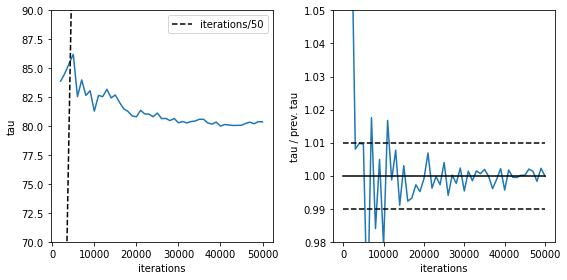

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
f.set_figheight(4)
f.set_figwidth(8)
n = 1000 * np.arange(2, index + 1)
#print(n)
#print(autocorr)
plotlength = 50

ax1.plot(n[0:plotlength-1],autocorr[1:plotlength])
ax1.plot(n[0:plotlength-1],n[0:plotlength-1]/50,'k--',label='iterations/50')
ax1.set_ylabel('tau')
ax1.set_xlabel('iterations')
ax1.set_ylim(70,90)
ax1.legend()
ax2.plot(n[0:plotlength-1],autocorr_ratio[1:plotlength])
ax2.plot([0,1000*plotlength],[1,1],color='k')
ax2.plot([0,1000*plotlength],[0.99,0.99],'k--')
ax2.plot([0,1000*plotlength],[1.01,1.01],'k--')
ax2.set_xlabel('iterations')
ax2.set_ylabel('tau / prev. tau')
ax2.set_ylim(0.98,1.05)
plt.tight_layout()
plt.show()
#ax3.plot(n,autocorr_diff[1:index])
#ax3.set_ylim(-0.01,1.1)